In [1]:
import pandas as pd
import gensim
import numpy as np
from sklearn.model_selection import KFold
import nltk
from nltk.corpus import stopwords
# Import textblob
from textblob import Word, TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

# choose_whole_fruits

## Data Preprocessing

In [2]:
df = pd.read_excel('Meals_w_Goals_deid_snapshot.xlsx', 'choose_whole_fruits')

In [3]:
df['meal_ingredients'].isnull().sum()

0

In [4]:
df = df.dropna(axis=0, subset=['meal_ingredients'])

In [5]:
df['meal_ingredients'].isnull().sum()

0

In [6]:
df['meal_ingredients'] = df['meal_ingredients'].astype(str)

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
def preprocess_meals(meal):
    processed_meal = meal
    processed_meal.replace('[^\w\s]', '')
    processed_meal = " ".join(word for word in processed_meal.split() if word not in stop_words)
    #processed_meal = " ".join(word for word in processed_meal.split() if word not in custom_stopwords)
    processed_meal = " ".join(Word(word).lemmatize() for word in processed_meal.split())
    return(processed_meal)

In [9]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
df['expert_assessment'] = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [10]:
total = df['expert_assessment'].count()
negative = df['expert_assessment'][df['expert_assessment']==0].count()
positive = df['expert_assessment'][df['expert_assessment']==1].count()
print('Total observations:', total)
print('Total negative labels:', negative)
print('Total positive labels:', positive)

Total observations: 385
Total negative labels: 286
Total positive labels: 99


# TFIDF


## Meal Ingredients

In [11]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [12]:
df['meal_ingredients']

0                                    Turkey burger salad
1                                          Chicken salad
2                                            Boiling egg
3                                              Bagel egg
4                                     Boiling egg coffee
                             ...                        
380                            Blueberries Walnuts Water
381                   Walnuts Almonds Blackberries Water
382                                  Almonds Apple Water
383                                 Tangerine üçä Water
384    Chicken Breast Chick Pease Jerked Seasoning Ol...
Name: meal_ingredients, Length: 385, dtype: object

In [13]:
document = []
for i in df['meal_ingredients']:
    if i != '':
        document.append(i)

In [14]:
document

['Turkey burger salad',
 'Chicken salad',
 'Boiling egg',
 'Bagel egg',
 'Boiling egg coffee',
 'Lentil soup',
 'Pepper onion tomato onion omelette',
 'Quinoa vegetable',
 'Salad sweet potato',
 'Vegetables',
 'Avocado drink diet Sunkist',
 'Milk',
 'Avocado , potato diet ginger ale',
 'Grapefruit',
 'Avocado,diet Ginger ale',
 'Steak,Season potato , Mac cheese water',
 'Waffel,bacon',
 'Almond,pecan,lettuce,grilled chicken,apple',
 'Steamed dinner> Salmon 4shrimp. Broc carrot steamed potato',
 '2 pkgs cream wheat one flavored 1 plain coffee 1 water',
 'Peach yogurt',
 'Coffee water 3 slice whole wheat tst margarine marmalade',
 'Tomatoes salad chiken cutlet',
 'Water Gatorade shrimp salad lettuce tomato rye bread',
 'Coffee. Water 2 instant sugar free oatmeal water....',
 'Water coffee chobani Greek yogurt',
 'Sweet potatoe pie 1/2 slice',
 'Lentils. Water coffee',
 'Turkey Swiss let tomato mayo Water. 8oz fresh squeeze juice',
 'Shrimp salad wrap w.w wrap Lettuce tomato avacado',
 'C

In [15]:
data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [17]:
print(X_train.shape, X_test.shape)

(308,) (77,)


In [18]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


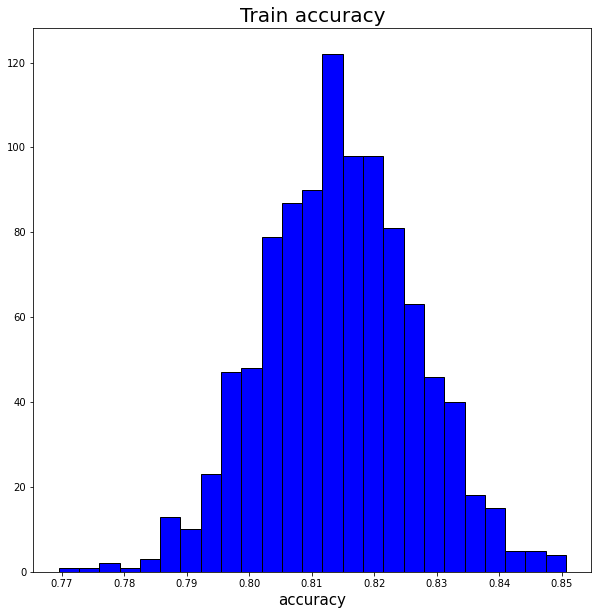

In [19]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [20]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8127337662337663
0.012204646942153955


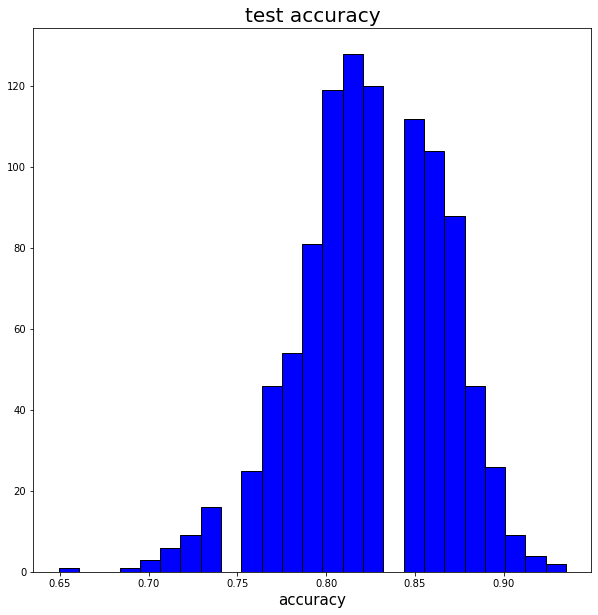

In [21]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [22]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8246493506493507
0.04068065679668092


# TFIDF Meal Title

In [23]:
df['meal_title'].isnull().sum()

0

In [24]:
df['meal_title'] = df['meal_title'].astype(str)

In [25]:
df = df.dropna(axis=0, subset=['meal_title'])

In [26]:
df['meal_title'].isnull().sum()

0

In [27]:
document = []
for i in df['meal_title']:
    if i != '':
        document.append(i)

In [28]:
data_X = np.squeeze(pd.DataFrame(df['meal_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [30]:
print(X_train.shape, X_test.shape)

(308,) (77,)


In [31]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

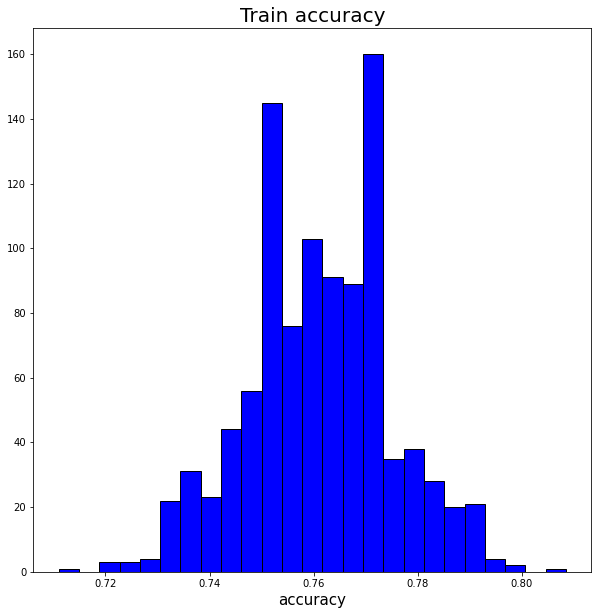

In [32]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [33]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.7607435064935065
0.01390183725334116


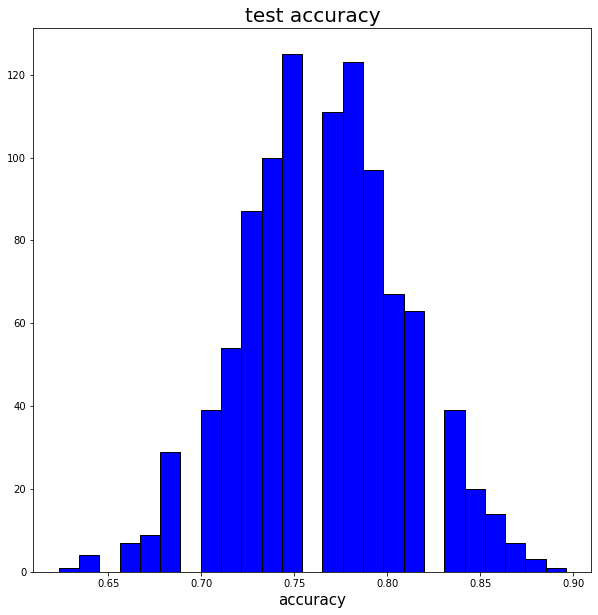

In [34]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [35]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.7653896103896103
0.04285866782017324


# TFIDF Ingredients + Title

In [36]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [37]:
document = []
for i in df['ingredients_and_title']:
    if i != '':
        document.append(i)

In [38]:
document

['Turkey burger salad Salad with turkey burger',
 'Chicken salad Chicken with mixed vegetables',
 'Boiling egg Boiling eggs with one cracker',
 'Bagel egg 1/2bagel with one egg',
 'Boiling egg coffee Coffee and egg',
 'Lentil soup Lentil soup',
 'Pepper onion tomato onion omelette Vegetables omelette',
 'Quinoa vegetable Quinoa and vegetables',
 'Salad sweet potato Salad ,sweet potatoes and avocado',
 'Vegetables Rice , chicken',
 'Avocado drink diet Sunkist Chicken soup, white rice',
 'Milk Cornmeal',
 'Avocado , potato diet ginger ale Rice broccoli , chicken',
 'Grapefruit Cup of fruit',
 'Avocado,diet Ginger ale Rice with gandules ,roasted chicken , potatoes',
 'Steak,Season potato , Mac cheese water Steak dinner',
 'Waffel,bacon Waffel',
 'Almond,pecan,lettuce,grilled chicken,apple Salad',
 'Steamed dinner> Salmon 4shrimp. Broc carrot steamed potato Wed nite fish nite...steamed',
 '2 pkgs cream wheat one flavored 1 plain coffee 1 water Up and on the go sat morn',
 'Peach yogurt Wat

In [39]:
data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [41]:
print(X_train.shape, X_test.shape)

(308,) (77,)


In [42]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


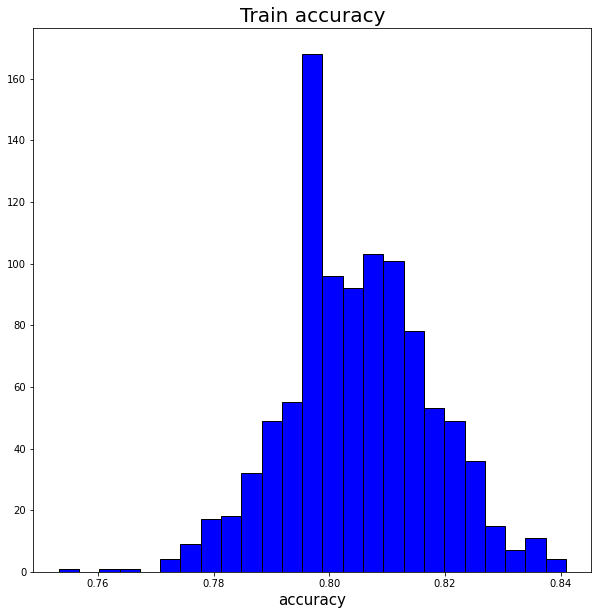

In [43]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [44]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8049772727272727
0.012636716920222668


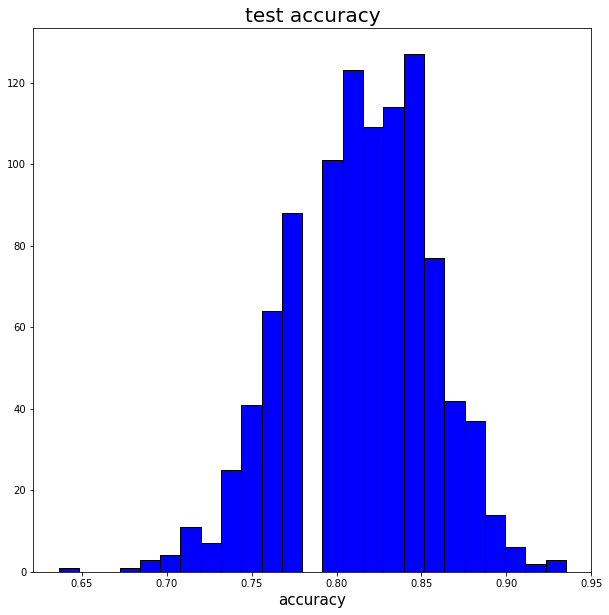

In [45]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [46]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8141948051948052
0.04156402356992523


# Word2vec

## ingredients

In [47]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [48]:
meal_ingredients = df.meal_ingredients.apply(gensim.utils.simple_preprocess)

In [49]:
meal_ingredients

0                                [turkey, burger, salad]
1                                       [chicken, salad]
2                                         [boiling, egg]
3                                           [bagel, egg]
4                                 [boiling, egg, coffee]
                             ...                        
380                        [blueberries, walnuts, water]
381              [walnuts, almonds, blackberries, water]
382                              [almonds, apple, water]
383                              [tangerine, üçä, water]
384    [chicken, breast, chick, pease, jerked, season...
Name: meal_ingredients, Length: 385, dtype: object

In [50]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients, progress_per = 100)

embeddings.train(meal_ingredients, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients = embeddings.wv.index_to_key

In [51]:
learned_words_meal_ingredients

['water',
 'oz',
 'chicken',
 'tomato',
 'salad',
 'egg',
 'rice',
 'cheese',
 'onion',
 'lettuce',
 'apple',
 'coffee',
 'bottle',
 'spinach',
 'steak',
 'one',
 'small',
 'milk',
 'plus',
 'potato',
 'glucerna',
 'bread',
 'oil',
 'sausage',
 'red',
 'green',
 'sauce',
 'bean',
 'yellow',
 'olive',
 'shrimp',
 'cabbage',
 'pepper',
 'mixed',
 'cup',
 'banana',
 'strawberry',
 'wheat',
 'dressing',
 'ham',
 'pork',
 'scrambled',
 'tomatoes',
 'whole',
 'cucumber',
 'beans',
 'hot',
 'avocado',
 'low',
 'ketchup',
 'garlic',
 'cherry',
 'turkey',
 'sugar',
 'orange',
 'soup',
 'eggs',
 'carrots',
 'sunflower',
 'corn',
 'slice',
 'mushroom',
 'half',
 'salt',
 'splenda',
 'sprout',
 'fry',
 'sandwich',
 'salmon',
 'bacon',
 'meat',
 'seed',
 'bbq',
 'carb',
 'pea',
 'brown',
 'peppers',
 'black',
 'cereal',
 'cheerios',
 'fat',
 'oatmeal',
 'roll',
 'two',
 'yogurt',
 'chop',
 'strawberries',
 'diet',
 'bowl',
 'bagel',
 'broccoli',
 'skirt',
 'fried',
 'onions',
 'olives',
 'ribs',
 '

In [52]:
words = []
for i in meal_ingredients:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [53]:
l = []
eg = 0
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [54]:
data_y = np.squeeze(data_y)
data_y.shape

(385,)

In [55]:
data_X = pd.DataFrame(l)
data_X.shape

(385, 100)

In [56]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

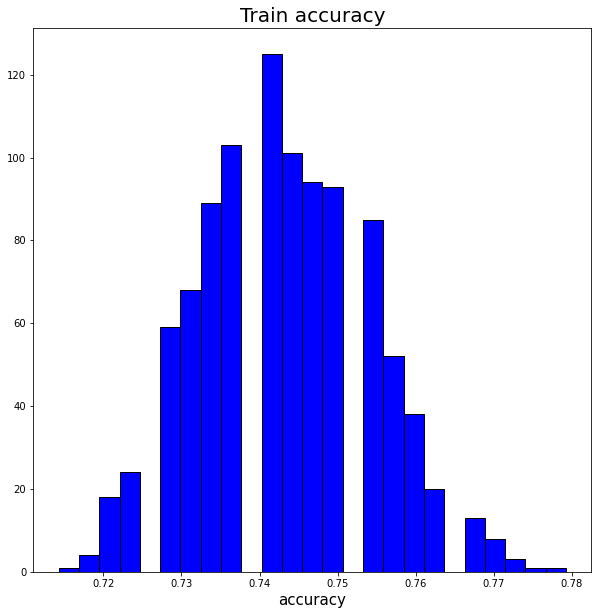

In [57]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [58]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.7427922077922078
0.010905225041678294


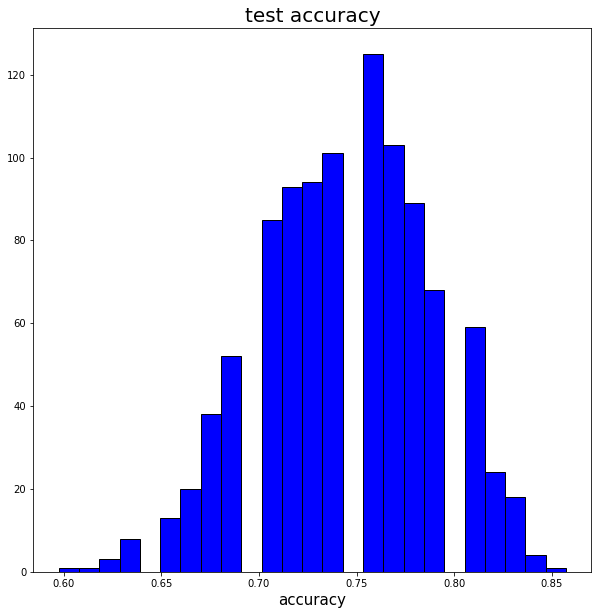

In [59]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [60]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.7431168831168832
0.04362090016671322


## title

In [61]:
df['meal_title'].isnull().sum()

0

In [62]:
df['meal_title'] = df['meal_title'].astype(str)

In [63]:
df = df.dropna(axis=0, subset=['meal_title'])

In [64]:
df['meal_title'].isnull().sum()

0

In [65]:
meal_title = df.meal_title.apply(gensim.utils.simple_preprocess)

In [66]:
meal_title

0                     [salad, with, turkey, burger]
1                [chicken, with, mixed, vegetables]
2               [boiling, eggs, with, one, cracker]
3                           [bagel, with, one, egg]
4                                [coffee, and, egg]
                           ...                     
380                                    [nut, snack]
381                                 [snack, treats]
382                                [morning, snack]
383                                         [water]
384    [jerked, chicken, breast, and, chick, pease]
Name: meal_title, Length: 385, dtype: object

In [67]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_title, progress_per = 100)

embeddings.train(meal_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_title = embeddings.wv.index_to_key

In [68]:
learned_words_meal_title

['and',
 'salad',
 'with',
 'chicken',
 'rice',
 'of',
 'water',
 'glucerna',
 'bottle',
 'steak',
 'eggs',
 'beans',
 'yellow',
 'fruit',
 'egg',
 'cheese',
 'mixed',
 'spinach',
 'sandwich',
 'shrimp',
 'ham',
 'soup',
 'red',
 'coffee',
 'pork',
 'cereal',
 'ribs',
 'breakfast',
 'bbq',
 'vegetables',
 'banana',
 'avocado',
 'bread',
 'meat',
 'veggies',
 'fish',
 'on',
 'oz',
 'cheerios',
 'sausage',
 'salmon',
 'for',
 'gandules',
 'dinner',
 'caesar',
 'apple',
 'cabbage',
 'cup',
 'meal',
 'wheat',
 'potato',
 'glass',
 'burger',
 'turkey',
 'broccoli',
 'test',
 'peas',
 'lettuce',
 'the',
 'stir',
 'fry',
 'whole',
 'black',
 'onions',
 'white',
 'potatoes',
 'tomato',
 'go',
 'bacon',
 'sugar',
 'quinoa',
 'grilled',
 'veggie',
 'half',
 'pizza',
 'one',
 'chop',
 'yogurt',
 'meatballs',
 'snack',
 'bar',
 'in',
 'day',
 'corn',
 'beef',
 'burritos',
 'bagel',
 'sweet',
 'nd',
 'roll',
 'sprouts',
 'frittata',
 'tso',
 'pasta',
 'hotdogs',
 'olives',
 'gral',
 'dunkin',
 'tom

In [69]:
words = []
for i in meal_title:
    temp = []
    for j in i:
        if j in learned_words_meal_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [70]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [71]:
data_y = np.squeeze(data_y)
data_y.shape

(385,)

In [72]:
data_X = pd.DataFrame(l)
data_X.shape

(385, 100)

In [73]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

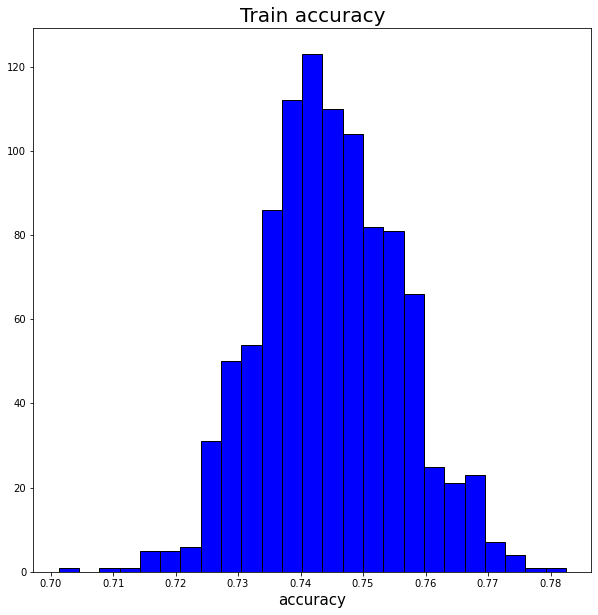

In [74]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [75]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.7431266233766235
0.011110971676707986


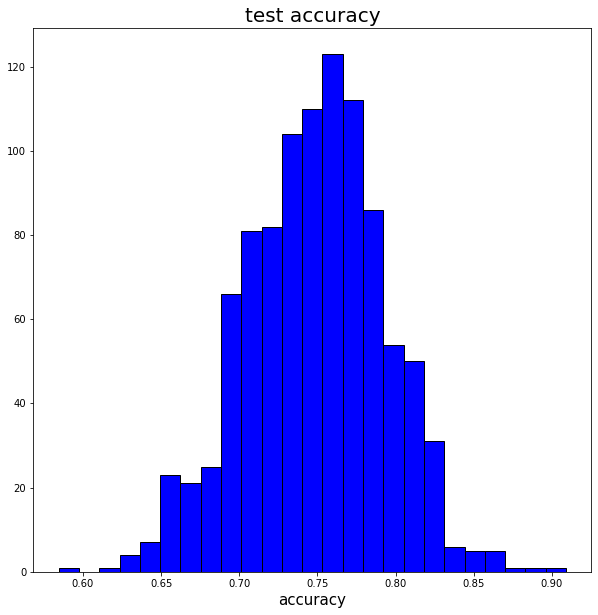

In [76]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [77]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.7417792207792206
0.04444388670683197


## ingredients_and_title

In [78]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [79]:
df['ingredients_and_title']

0           Turkey burger salad Salad with turkey burger
1            Chicken salad Chicken with mixed vegetables
2              Boiling egg Boiling eggs with one cracker
3                        Bagel egg 1/2bagel with one egg
4                      Boiling egg coffee Coffee and egg
                             ...                        
380                  Blueberries Walnuts Water Nut Snack
381      Walnuts Almonds Blackberries Water Snack Treats
382                    Almonds Apple Water Morning Snack
383                           Tangerine üçä Water Water
384    Chicken Breast Chick Pease Jerked Seasoning Ol...
Name: ingredients_and_title, Length: 385, dtype: object

In [80]:
meal_ingredients_title = df.ingredients_and_title.apply(gensim.utils.simple_preprocess)

In [81]:
meal_ingredients_title

0      [turkey, burger, salad, salad, with, turkey, b...
1      [chicken, salad, chicken, with, mixed, vegetab...
2      [boiling, egg, boiling, eggs, with, one, cracker]
3                    [bagel, egg, bagel, with, one, egg]
4               [boiling, egg, coffee, coffee, and, egg]
                             ...                        
380            [blueberries, walnuts, water, nut, snack]
381    [walnuts, almonds, blackberries, water, snack,...
382              [almonds, apple, water, morning, snack]
383                       [tangerine, üçä, water, water]
384    [chicken, breast, chick, pease, jerked, season...
Name: ingredients_and_title, Length: 385, dtype: object

In [82]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients_title, progress_per = 100)

embeddings.train(meal_ingredients_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients_title = embeddings.wv.index_to_key

In [83]:
learned_words_meal_ingredients_title

['water',
 'and',
 'salad',
 'chicken',
 'oz',
 'rice',
 'egg',
 'with',
 'cheese',
 'bottle',
 'tomato',
 'glucerna',
 'steak',
 'of',
 'apple',
 'lettuce',
 'coffee',
 'onion',
 'spinach',
 'yellow',
 'eggs',
 'beans',
 'mixed',
 'shrimp',
 'red',
 'one',
 'small',
 'bread',
 'ham',
 'potato',
 'sausage',
 'milk',
 'pork',
 'cabbage',
 'banana',
 'fruit',
 'cup',
 'soup',
 'plus',
 'sandwich',
 'sauce',
 'oil',
 'green',
 'wheat',
 'bean',
 'olive',
 'pepper',
 'whole',
 'avocado',
 'strawberry',
 'cereal',
 'bbq',
 'tomatoes',
 'turkey',
 'cucumber',
 'dressing',
 'ribs',
 'scrambled',
 'meat',
 'sugar',
 'salmon',
 'cheerios',
 'orange',
 'corn',
 'low',
 'fry',
 'garlic',
 'half',
 'bacon',
 'ketchup',
 'carrots',
 'slice',
 'hot',
 'black',
 'onions',
 'glass',
 'gandules',
 'broccoli',
 'yogurt',
 'burger',
 'breakfast',
 'roll',
 'cherry',
 'caesar',
 'vegetables',
 'mushroom',
 'white',
 'beef',
 'sunflower',
 'chop',
 'brown',
 'splenda',
 'salt',
 'oatmeal',
 'bagel',
 'swee

In [84]:
words = []
for i in meal_ingredients_title:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [85]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [86]:
data_y = np.squeeze(data_y)
data_y.shape

(385,)

In [87]:
data_X = pd.DataFrame(l)
data_X.shape

(385, 100)

In [88]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

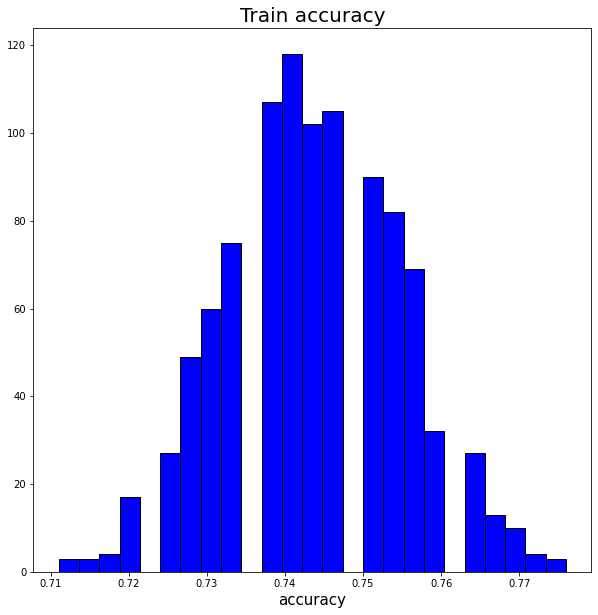

In [89]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [90]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.7433571428571429
0.011241403829625478


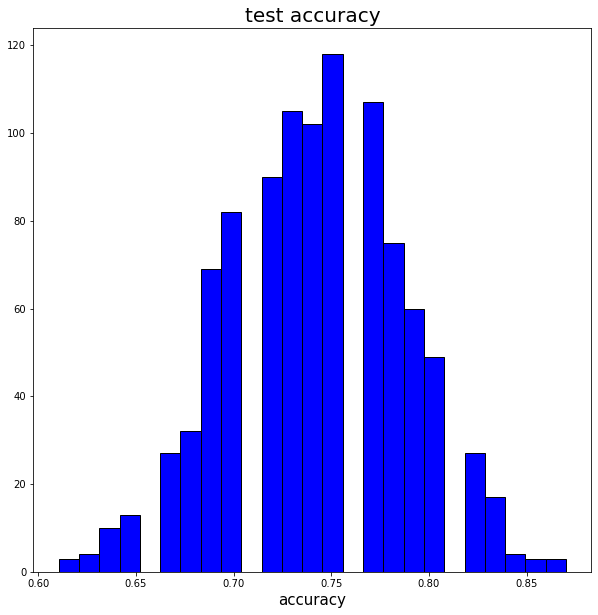

In [91]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [92]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.7408571428571428
0.04496561531850195
